<a href="https://colab.research.google.com/github/a-mironov/datascience-module2/blob/main/module2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Import

In [1]:
# setup / necessary imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings

from IPython.display import set_matplotlib_formats
warnings.filterwarnings('ignore')
%matplotlib inline
set_matplotlib_formats('png')

# custom exception for dummy variable creation method
class CategoryNotFoundException(Exception):
  pass

reading the dataset

In [3]:
# read dataset

path_to_dataset = './drive/MyDrive/DATASCIENCE/DATA/bank-additional-full.csv'
try:
  df_1 = pd.read_csv(path_to_dataset, sep=';', on_bad_lines = 'error')
except FileNotFoundError:
  print("File not found!")
# except ParserError:
#   print("Failed to parse lines")
else:
  print("File found and parsed.")


File found and parsed.


# Data Introduction

In [ ]:
df_1.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

lots of variables here, so let's sort the categorical from the numerical.

In [ ]:
vars_numerical = df_1.select_dtypes('number').columns
vars_categorical = df_1.select_dtypes(np.object).columns

vars_numerical

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

# Categorical Variable Processing

We convert all categorical variables into numerical dummy variables in the most straightforward way possible, i.e. by converting the possible values of each into numbers 1, 2, etc. In all cases except 'y', the output variable, "unknown" is assigned to the number 0. Unknown labels are included even for variables that `bank-additional-names.txt` did not explicitly specify could take unknown values.



In [ ]:
# writing down the sets of values for categorical variables
# pulled from bank-additional-names.txt by hand
# colab uses Python 3.8.5, so no switch statements! i have to do it with
# a dozen elifs.
def get_value_set(vartype):
  if vartype == 'job':
      return ["unknown","admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed"]
  elif vartype == 'marital':
      return ["unknown","divorced","married","single"]
  elif vartype == 'education':
      return ["unknown","basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree"]
  elif vartype == 'default' | 'housing' | 'loan':
      return ["unknown","no","yes"]
  elif vartype == 'contact':
      return ["unknown","cellular","telephone"]
  elif vartype == 'month':
      return ["unknown","jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
  elif vartype == 'day_of_week':
      return ["unknown","mon","tue","wed","thu","fri"]
  elif vartype == 'poutcome':
      return ["unknown","failure","nonexistent","success"]
  elif vartype == 'y':
      return ["no", "yes"]
  else:
      raise CategoryNotFoundException
      return []

# writing my own dummy variable creation function,
# as it was not clear exactly how pd.get_dummies assigns values
# to its variables
def numerify_dataframe(df):
  for var in df.columns:
    if df[var].dtype == np.object:
      try:
        values = get_value_set(var)
      except CategoryNotFoundException:
        print("Could not convert to dummies -- bad variable (" + var + ") found!")
      var_newname = var + "_D"
      # duplicate relevant column
      df[var_newname] = df.loc[:, var]
      for i in df[var_newname].index:
        df[i, var_newname] = values.index(df[i, var_newname])

numerify_dataframe(df_1)

KeyError: ignored

In [ ]:
df_1.index

RangeIndex(start=0, stop=41188, step=1)

# Univariate Analysis

In [ ]:
df_1['age'].describe()

count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64

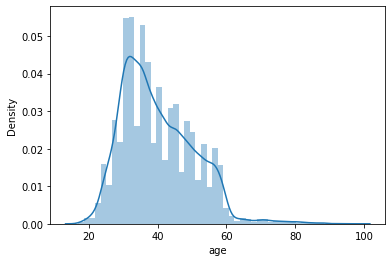

In [ ]:
sns.distplot(df_1['age'])

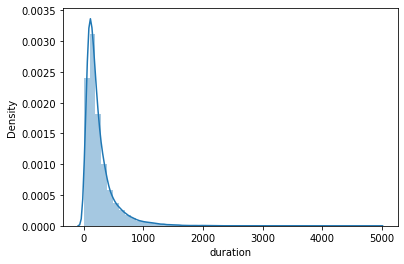

In [ ]:
sns.distplot(df_1['duration'])

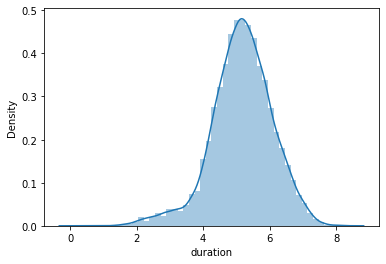

In [ ]:
sns.distplot(np.log(df_1[df_1['duration']!=0]['duration']))

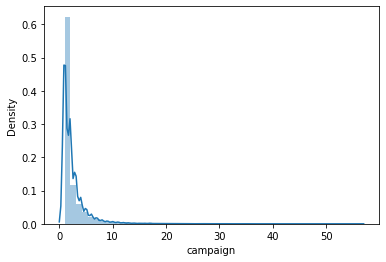

In [ ]:
sns.distplot(df_1['campaign'])

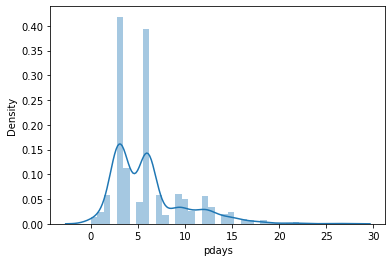

In [ ]:
sns.distplot(df_1[df_1['pdays']!=999]['pdays'])

# Bivariate Analysis

Below is the correlogram of all numerical variables in the dataset.

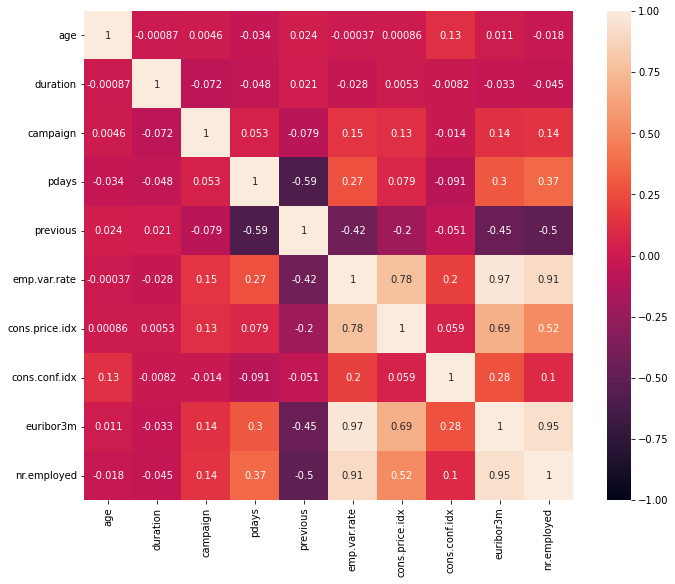

In [22]:
correl = df_1.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(correl, vmin = -1, square=True, annot=True);

Some highly correlated pairs of variables are immediately apparent:

`emp.var.rate` ~ `euribor3m` ~ `nr.employed`.

There are also some weaker correlations:

`cons.price.idx` ~ `euribor3m`, `cons.price.idx` ~ `emp.var.rate`; <br> `previous` ~ `-pdays`.

To avoid multicollinearity in a linear model, the first trio of correlated variables should

In [28]:
vars_categorical = df_1.select_dtypes(np.object).columns

categorical_corr = pd.DataFrame(index = vars_categorical, columns = vars_categorical)

for var1 in vars_categorical:
  for var2 in vars_categorical:
    crosstab_v1v2 = pd.crosstab(df_1[var1], df_1[var2])
    _, p, _, _ = stats.chi2_contingency(crosstab_v1v2)
    categorical_corr.loc[var1, var2] = p

print(categorical_corr)

# sns.heatmap(categorical_corr, vmin = 0, annot = True, fmt = "1.2f", square = True)

                  job   marital education   default   housing      loan  \
job               0.0       0.0       0.0       0.0  0.089963  0.104587   
marital           0.0       0.0       0.0       0.0  0.044216  0.766662   
education         0.0       0.0       0.0       0.0  0.011809  0.453624   
default           0.0       0.0       0.0       0.0  0.010301  0.379319   
housing      0.089963  0.044216  0.011809  0.010301       0.0       0.0   
loan         0.104587  0.766662  0.453624  0.379319       0.0       0.0   
contact           0.0       0.0       0.0       0.0       0.0  0.000002   
month             0.0       0.0       0.0       0.0       0.0  0.000066   
day_of_week  0.000077   0.00868       0.0    0.0175  0.001209   0.19782   
poutcome          0.0       0.0       0.0       0.0  0.000014   0.80923   
y                 0.0       0.0       0.0       0.0  0.058294  0.578675   

              contact     month day_of_week  poutcome         y  
job               0.0       0.0  